<a href="https://colab.research.google.com/github/cjkreienkamp/wpolo-scoresheet-ocr/blob/main/data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Configure Environment

### 0.1 Imports

In [1]:
!pip install pdf2image 1> /dev/null
!apt-get install poppler-utils 1> /dev/null
!pip install ipympl 1> /dev/null

In [2]:
import cv2
import numpy as np
import os
import pdf2image
from google.colab import output
output.enable_custom_widget_manager()
#%matplotlib ipympl
#import matplotlib
import matplotlib.pyplot as plt
import imutils
from imutils import contours
import shutil

### 0.2 Create folder structure

In [3]:
if not os.path.exists('input'): os.symlink('/content/drive/MyDrive/input', 'input')
if not os.path.exists('output/aligned'): os.makedirs('output/aligned')
if not os.path.exists('output/my_shitty_data'): os.makedirs('output/my_shitty_data')

## 1. Load Data

### 1.0 Functions

### 1.1 Convert scoresheets PDF --> PNG

In [4]:
for pdf in os.listdir('input/scoresheet_pdfs'):
    if not pdf[:-4]+'.txt' in os.listdir('input/gamelog_corner_pts'):
        print('Missing gamelog corner points for '+pdf[:-4]+'.png')
    if not pdf[:-4]+'.png' in os.listdir('input/scoresheet_pngs'):
        png = convert_from_path('input/scoresheet_pdfs/'+pdf, 500)[0]
        png.save('input/scoresheet_pngs/'+pdf[:-4]+'.png', 'PNG')

### 1.2 OPTIONAL Select the corners of each gamelog in a scoresheet and save to a txt file

In [ ]:
scoresheet = cv2.imread('input/scoresheet_pngs/scoresheet15.png')

fig, ax = plt.subplots()
fig.set_size_inches(33, 25.5)
plt.imshow(scoresheet)

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix)
    print(iy)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
data = '''137.4276637341154
3561.27908113392
1390.409090909091
3574.573313782991
124.1334310850441
5309.470674486804
1367.1441837732164
5312.794232649072
1456.8802541544478
3574.573313782991
2686.5967741935488
3574.573313782991
1433.6153470185727
5319.441348973607
2666.6554252199417
5312.794232649072
2756.391495601173
3574.573313782991
3992.75513196481
3581.220430107527
2739.7737047898336
5312.794232649072
3979.460899315738
5319.441348973607
4059.2262952101664
3574.573313782991
5292.266373411535
3577.896871945259
4039.2849462365593
5306.147116324536
5275.648582600195
5312.794232649072
5358.737536656892
3584.5439882697947
6591.777614858261
3584.5439882697947
5338.796187683285
5319.441348973607
6568.512707722385
5326.088465298143'''

with open('input/gamelog_corner_pts/scoresheet15.txt', 'x') as f:
    f.write(data)

### 1.3 Identify, straighten, and save the gamelogs from each scoresheet

In [26]:
gamelog_height = 500
gamelog_width = 369
gamelog_template_corners = np.array([[0,0], [gamelog_width,0], [0,gamelog_height], [gamelog_width,gamelog_height]])
for png in os.listdir('input/scoresheet_pngs'):
    img = cv2.imread('input/scoresheet_pngs/'+png)
    with open('input/gamelog_corner_pts/'+png[:-4]+'.txt', 'r') as f:
        data = f.read().split('\n')
        for i in range(5):
            gamelog_corners = np.array([[float(data[i*8+0]), float(data[i*8+1])],
                                        [float(data[i*8+2]), float(data[i*8+3])],
                                        [float(data[i*8+4]), float(data[i*8+5])],
                                        [float(data[i*8+6]), float(data[i*8+7])]])
            (H, mask) = cv2.findHomography(gamelog_corners, gamelog_template_corners, method=cv2.RANSAC)
            aligned = cv2.warpPerspective(img, H, (gamelog_width, gamelog_height))
            cv2.imwrite('output/aligned/'+png[5:-4]+'_log'+str(i+1)+'.png',aligned)

### 1.4 Draw lines between every cell on the gamelog template

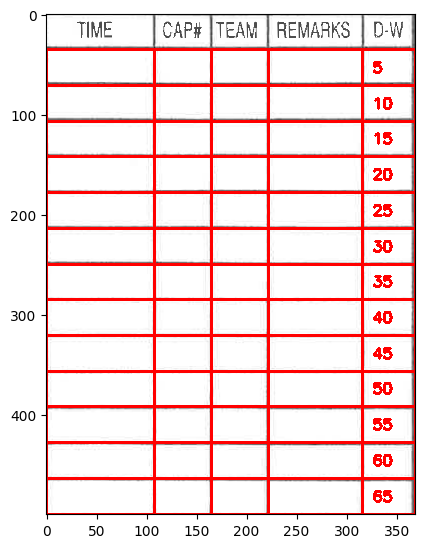

In [29]:
COLUMN_NUMBERS = [0]
NUMBER_OF_ROWS = 14
column_x_values = [0,108,165,222,316,gamelog_width]
gamelog_bb_cell = cv2.imread('output/aligned/sheet13_log5.png')

##### ----- ^^^^^ INPUT ^^^^^ ----- #####

row_y_values = [int(gamelog_height/NUMBER_OF_ROWS*(i+1)) for i in range(NUMBER_OF_ROWS)]
n_cell = 0
for y1 in row_y_values[:-1]:
    for x1 in column_x_values[:-1]:
        n_cell += 1
        x2 = column_x_values[column_x_values.index(x1)+1]
        y2 = row_y_values[row_y_values.index(y1)+1]
        cv2.rectangle(gamelog_bb_cell, (x1, y1), (x2, y2), (255,0,0), 2)
        if n_cell%5 in COLUMN_NUMBERS:
            cv2.putText(gamelog_bb_cell, str(n_cell), (int((x1+x2)/2.1), int((y1+y2)/2+5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

plt.figure(figsize=(5,5))
plt.imshow(gamelog_bb_cell)
plt.subplots_adjust(top=1, bottom=0, left=-0.3, right=1.3)
plt.show()

## 2. Save Data

### 2.1 Save every desired cell as its own image

In [30]:
!rm output/my_shitty_data/*

In [31]:
for png in os.listdir('output/aligned'):
    image = cv2.imread('output/aligned/'+png)
    n_cell = 0
    for y1 in row_y_values[:-1]:
        for x1 in column_x_values[:-1]:
            n_cell += 1
            if n_cell%5 in COLUMN_NUMBERS:
                x2 = column_x_values[column_x_values.index(x1)+1]
                y2 = row_y_values[row_y_values.index(y1)+1]
                row_number = (int(png[-5])-1)*(NUMBER_OF_ROWS-1) + n_cell//5 + 1
                if n_cell%5 == 2: column_name = 'CAP'
                if n_cell%5 == 3: column_name = 'TEAM'
                if n_cell%5 == 4: column_name = 'REMARKS'
                if n_cell%5 == 0: column_name = 'SCORE'
                cell = image[y1:y2, x1:x2]
                cv2.imwrite(f'output/my_shitty_data/sheet{png[5:-9]}_row{row_number}.png',cell)

### 2.2 OPTIONAL: Analyze data in cell

----------> [ 84 487 749 459 147 640 534 502 198 731 634 680 182 565 751 646 817 176
 176 409  35 383 553 377 716 591 401  23 666 328 870  22 681  80 265 173
 894 897 684 690 193 281 593 623 583 457 281   9 621 331]


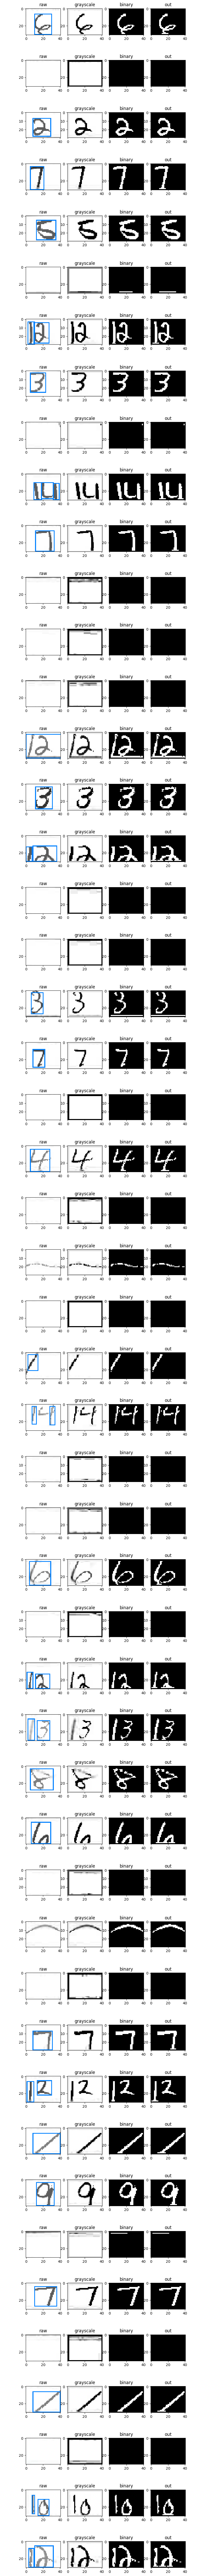

In [54]:
# CAP

idxs = np.random.randint(0, len(os.listdir('output/my_shitty_data')), 50)
#idxs = [171, 269, 177, 80, 655, 873, 521, 638, 532, 308]
print('---------->',idxs)
plt.figure(figsize=(8,2*len(idxs)))


for (i, idx) in zip(range(50),idxs):
    png = os.listdir('output/my_shitty_data')[int(idx)]
    raw = cv2.imread('output/my_shitty_data/'+png)
    grayscale = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    cv2.rectangle(grayscale, (0,0), (raw.shape[1], raw.shape[0]), (240,240,240), 2)
    binary = cv2.threshold(grayscale, 230, 255, cv2.THRESH_BINARY_INV)[1]
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    out = cv2.dilate(binary, element, iterations=2)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1)) # want to connect horizontally at the top
    out[0:2, 0:out.shape[1]] = cv2.dilate(out[0:2, 0:out.shape[1]], element, iterations=2)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1)) # want to connect horizontally at the bottom
    out[out.shape[0]-2:out.shape[0], 0:out.shape[1]] = cv2.dilate(out[out.shape[0]-2:out.shape[0], 0:out.shape[1]], element, iterations=2)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    out = cv2.erode(out, element)
    ctrs = cv2.findContours(out.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    ctrs = imutils.grab_contours(ctrs)
    if len(ctrs):
        ctrs = contours.sort_contours(ctrs, method="left-to-right")[0]
        for c in ctrs:
            (x, y, w, h) = cv2.boundingRect(c)
            if w*h > 50 and y < 15 and y+h > 15 and h > 10:
                cv2.rectangle(raw, (x, y), (x + w, y + h), (0, 128, 255), 1)

    plt.subplot(50,4,4*i+1); plt.title('raw'); plt.imshow(raw, aspect='equal')
    plt.subplot(50,4,4*i+2); plt.title('grayscale'); plt.imshow(grayscale, cmap='gray', aspect='equal')
    plt.subplot(50,4,4*i+3); plt.title('binary'); plt.imshow(binary, cmap='gray', aspect='equal')
    plt.subplot(50,4,4*i+4); plt.title('out'); plt.imshow(out, cmap='gray', aspect='equal')

plt.subplots_adjust(top=1, bottom=0)
plt.show()
#close 366, 379
#light 171, 269, 177, 80, 655
#broken 873, 521, 713, 352, 417, 336, 731
#border 638, 532, 308
#HC 55
# smear then pad
#if at border the dilate

### 2.3 Export data

In [33]:
shutil.make_archive('score', 'zip', 'output/my_shitty_data/')

'/content/score.zip'

# 9. Unused

In [ ]:
def rotate(x):
  x_rotated = []
  for i in range(x.shape[0]):
    img = Image.fromarray(x[i])
    img = img.rotate(90)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    x_rotated.append(np.array(img))
  x_rotated = np.array(x_rotated)
  return x_rotated

In [ ]:
dataset = torchvision.datasets.MNIST(root='data', train=True, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12834933.16it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 347466.03it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2745620.53it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3209320.88it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### 1.2 Visualize the data

image shape: torch.Size([60000, 28, 28])
label shape: torch.Size([60000])
classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


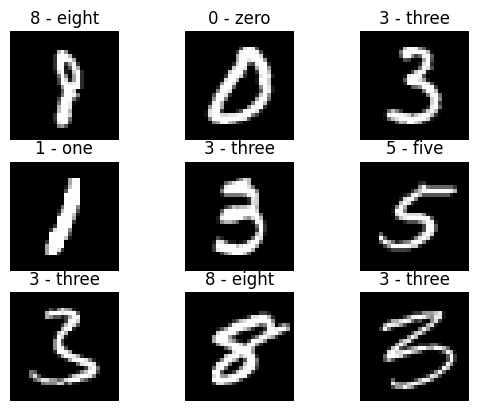

In [ ]:
classes = dataset.classes
NUM_CLASSES = len(classes)

print('image shape:',dataset.data.shape)
print('label shape:',dataset.targets.shape)
print('classes:',classes)

random_sample = np.random.randint(0, dataset.data.shape[0], 9)
for i , sample in zip(range(9), random_sample):
  image, label = dataset[sample]
  plt.subplot(3, 3, i + 1)
  plt.imshow(image, cmap="gray")
  plt.title(classes[label])
  plt.axis("off")
plt.show()

## 2. Prepare Data

### 2.1 Convert data to tensors and resize

In [ ]:
transform=torchvision.transforms.Compose([transforms.ToTensor()])
dataset_tensor = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
val_tensor = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
print('tensor shape:',dataset_tensor.data.shape)

tensor shape: torch.Size([60000, 28, 28])


### 2.2 Split the dataset into train, test, and validation

* training set - used to train the model, compute the loss, and adjust the weights of the model using gradient descent

* test set - used to evaluate the training model, adjust the hyperparameters, and pick the best version of the model

* validation set - used as a final check of model predictions on new data to evaluate model performance

In [ ]:
train_tensor, test_tensor = random_split(dataset_tensor, [0.8, 0.2])

print('samples in train dataset: ', len(train_tensor))
print('samples in test dataset: ', len(test_tensor))
print('samples in validation dataset: ', len(val_tensor))

samples in train dataset:  48000
samples in test dataset:  12000
samples in validation dataset:  10000


### 2.3 Convert to dataloaders

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(train_tensor, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_tensor, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle = False)

img_custom, label_custom = next(iter(train_dataloader))
print(f"Dataloader image shape: {img_custom.shape} --> [batch_size, color_channels, height, width]")
print(f"Dataloader label shape: {label_custom.shape}")

DATALOADER_COLOR_CHANNELS = img_custom.shape[1]
DATALOADER_HEIGHT = img_custom.shape[2]
DATALOADER_WIDTH = img_custom.shape[3]

Creating DataLoader's with batch size 128 and 2 workers.
Dataloader image shape: torch.Size([128, 1, 28, 28]) --> [batch_size, color_channels, height, width]
Dataloader label shape: torch.Size([128])


## 3. Download Data